In [1]:
# Import libraries for simulation
import tensorflow as tf
import numpy as np

# Imports for visualization
import PIL.Image
from cStringIO import StringIO
from IPython.display import clear_output, Image, display
import scipy.ndimage as nd

In [2]:
def DisplayFractal(a, fmt='jpeg'):
  """Display an array of iteration counts as a
     colorful picture of a fractal."""
  a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
  img = np.concatenate([10+20*np.cos(a_cyclic),
                        30+50*np.sin(a_cyclic),
                        155-80*np.cos(a_cyclic)], 2)
  img[a==a.max()] = 0
  a = img
  a = np.uint8(np.clip(a, 0, 255))
  f = StringIO()
  PIL.Image.fromarray(a).save(f, fmt)
  display(Image(data=f.getvalue()))

In [3]:
sess = tf.InteractiveSession()
# Use NumPy to create a 2D array of complex numbers on [-2,2]x[-2,2]

Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]
Z = X+1j*Y
xs = tf.constant(Z.astype(np.complex64))
zs = tf.Variable(xs)
ns = tf.Variable(tf.zeros(Z.shape))
tf.initialize_all_variables().run()

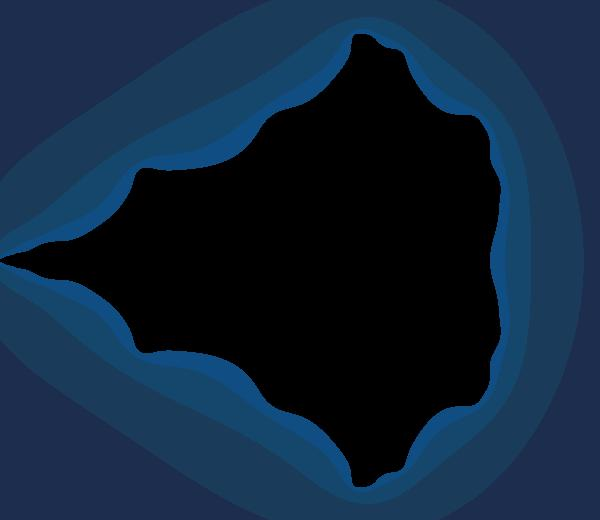

In [4]:
# Compute the new values of z: z^2 + x
zs_ = zs*zs + xs

# Have we diverged with this new value?
not_diverged = tf.complex_abs(zs_) < 4

# Operation to update the zs and the iteration count.
#
# Note: We keep computing zs after they diverge! This
#       is very wasteful! There are better, if a little
#       less simple, ways to do this.
#
step = tf.group(
  zs.assign(zs_),
  ns.assign_add(tf.cast(not_diverged, tf.float32))
  )
for i in range(5): step.run()
DisplayFractal(ns.eval())

In [5]:
def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  """Display an array as a picture."""
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = StringIO()
  PIL.Image.fromarray(a).save(f, fmt)
  display(Image(data=f.getvalue()))

In [6]:
sess = tf.InteractiveSession()

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x10e94b190>> ignored


In [7]:
def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]

def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)

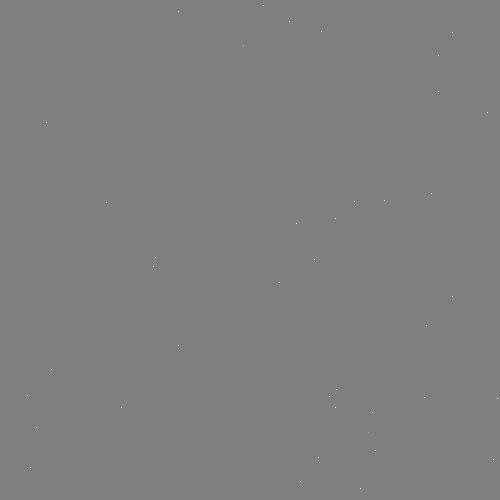

In [8]:
N = 500
# Initial Conditions -- some rain drops hit a pond

# Set everything to zero
u_init = np.zeros([N, N], dtype=np.float32)
ut_init = np.zeros([N, N], dtype=np.float32)

# Some rain drops hit a pond at random points
for n in range(40):
  a,b = np.random.randint(0, N, 2)
  u_init[a,b] = np.random.uniform()

DisplayArray(u_init, rng=[-0.1, 0.1])

In [9]:
# Parameters:
# eps -- time resolution
# damping -- wave damping
eps = tf.placeholder(tf.float32, shape=())
damping = tf.placeholder(tf.float32, shape=())

# Create variables for simulation state
U  = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

# Discretized PDE update rules
U_ = U + eps * Ut
Ut_ = Ut + eps * (laplace(U) - damping * Ut)

# Operation to update the state
step = tf.group(
  U.assign(U_),
  Ut.assign(Ut_))

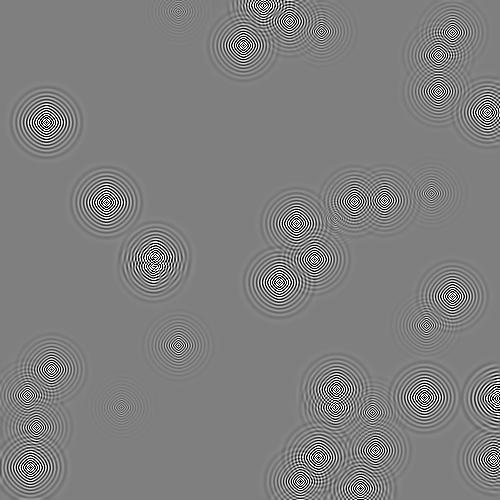

In [10]:
# Initialize state to initial conditions
tf.initialize_all_variables().run()

# Run 1000 steps of PDE
for i in range(1000):
  # Step simulation
  step.run({eps: 0.03, damping: 0.04})
  # Visualize every 50 steps
  if i % 50 == 0:
    clear_output()
    DisplayArray(U.eval(), rng=[-0.1, 0.1])